In [1]:
#Import libraries
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator


# seaborn graphing parameters
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("BuGn_r")
sns.set(font_scale=1.4) 

# ml algos
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import f1_score

pd.options.display.max_rows = 30
pd.options.display.max_columns = 30

In [2]:
#import csv for Austin B-Cycle Trip data
#commented out
#bcycle = pd.read_csv('Austin_B-Cycle_Trips.csv', encoding='latin1')
bcycle = pd.read_pickle('./bcycle_cleaned.pkl')
#bcycle.to_pickle('./Austin_B-Cycle_Trips.pkl')

In [3]:
#import csv for private dockless rideshare co's
#commented out:
#dockless = pd.read_csv('Dockless_Vehicle_Trips.csv', encoding='latin1')
dockless = pd.read_pickle('./dockless_cleaned.pkl')
#dockless.to_pickle('./Dockless_Vehicle_Trips.pkl')

# Notebook III: Feature Engineering

## 1. Average speed
## 2. Trip counter per unique device id 
## 3. An odometer per unique device id
## 4. Category for whether a trip is a "real ride" or "false start"
## 5. Downcast new features 

----------
----------
----------

# Average Speed

## 1a. Avg Speed for Dockless

In [4]:
# speed = distance / time. Creating a new column for avg speed.
dockless['avg_speed'] = round((dockless['trip_distance'] / 
                               dockless['trip_duration_seconds']), 2)

In [5]:
#Calling the variable again to not include the new 'avg_speed' column
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['trip_duration_seconds'] >= 1)]

In [6]:
#Calling the variable again to no include the new 'avg_speed' column
normal_dockless_rides_s = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'scooter')
                                    & (dockless['trip_duration_seconds'] >= 1)]

normal_dockless_rides_b = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'bicycle')
                                    & (dockless['trip_duration_seconds'] >= 1)]

## Dockless scooter mean & median avg speed

In [7]:
# mean
normal_dockless_rides_s['avg_speed'].mean()

2.48725015034398

In [8]:
# median
normal_dockless_rides_s['avg_speed'].median()

2.39

## Dockless bike mean & median avg speed

In [9]:
# mean
normal_dockless_rides_b['avg_speed'].mean()

3.360458308447479

In [10]:
# median
normal_dockless_rides_b['avg_speed'].median()

3.32

## 1b. Avg Speed for BCycle

## Thee is no trip distance information in BCycle. By relying on the avg speed from the bikes in the Dockless data set, it can be used as a proxy for BCycle

In [11]:
# saving this variable to use in Bcycle; meters / second
avg_bike_speed = normal_dockless_rides_b['avg_speed'].mean()

In [12]:
# distance = speed x time; rounding up to conserve space
bcycle['trip_distance'] = round((avg_bike_speed * bcycle.trip_duration_seconds), 2)

# Number of trips per unique device

## 2a. The number of trips per unique device in dockless

In [13]:
# new variable to measure length of dataset
device_id_set_length_dock = len(set(dockless['device_id']))

# Dictionary to store cumulative counts
device_id_dict_dock = dict(zip(set(dockless['device_id']), 
                               np.zeros(device_id_set_length_dock)))

# Empty list to store running count
running_count_dock = []
# Loop through all values
for row in dockless.itertuples():
    device_id_dict_dock[row[2]] += 1
    running_count_dock.append(device_id_dict_dock[row[2]])

dockless['device_id_trip_count'] = running_count_dock

## Verify that a randon device_id is getting counted

In [14]:
dockless.loc[dockless.device_id == '746fbee1-3a56-4275-8f0f-b36862d1bb53']

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count
31586,4290a0f9-4c21-483a-a130-3914a960b6f3,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,688,1325,04/06/2019 07:15:00 PM,04/06/2019 07:30:00 PM,4,19,6,2019,1554552900,1554553800,11.47,1.93,1.0
2121437,6c6883c8-6f25-4436-8b17-abf73011e939,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,205,692,03/11/2019 04:45:00 PM,03/11/2019 04:45:00 PM,3,16,1,2019,1552297500,1552297500,3.42,3.38,2.0
2124150,4c89f32a-2f22-48e3-828a-e7cc1e16b636,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,514,2100,12/27/2018 04:15:00 PM,12/27/2018 04:15:00 PM,12,16,4,2018,1545905700,1545905700,8.57,4.09,3.0
2126497,48d5b3c2-4a0b-4602-a586-afed48a06402,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,1133,1900,10/10/2018 06:00:00 PM,10/10/2018 06:15:00 PM,10,18,3,2018,1539169200,1539170100,18.88,1.68,4.0
2134238,2e919792-d0ab-47fe-9037-8a035db3edf2,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,764,2782,03/09/2019 10:00:00 PM,03/09/2019 10:15:00 PM,3,22,6,2019,1552147200,1552148100,12.73,3.64,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211027,f44e8bcc-f65a-4f96-8e4a-f86f6e9aa3d6,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,276,800,10/28/2018 09:45:00 AM,10/28/2018 10:00:00 AM,10,9,0,2018,1540737900,1540738800,4.60,2.90,249.0
3211658,e0a9623c-73c7-4b7c-b737-6468fc40d699,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,1741,3831,02/02/2019 07:15:00 PM,02/02/2019 07:45:00 PM,2,19,6,2019,1549113300,1549115100,29.02,2.20,250.0
3211785,047b00b6-599c-48d2-80be-993bb60962db,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,533,1256,01/26/2019 01:00:00 PM,01/26/2019 01:15:00 PM,1,13,6,2019,1548486000,1548486900,8.88,2.36,251.0
3215557,5173b7e0-b83b-46d1-8ae6-b622dfa030fc,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,301,1687,02/06/2019 07:00:00 AM,02/06/2019 07:15:00 AM,2,7,3,2019,1549458000,1549458900,5.02,5.60,252.0


## 2b. The number of trips per unique device in bcycle

In [15]:
# new variable to measure length of dataset
device_id_set_length_bcycle = len(set(bcycle['bicycle_id']))

# Dictionary to store cumulative counts
device_id_dict_bcycle = dict(zip(set(bcycle['bicycle_id']), np.zeros(device_id_set_length_bcycle)))

# Empty list to store running count
running_count_bcycle = []

# Loop through all values; the row has to be changed to 3 to count the bicycle_id column
for row in bcycle.itertuples():
    device_id_dict_bcycle[row[3]] += 1
    running_count_bcycle.append(device_id_dict_bcycle[row[3]])

bcycle['device_trip_count'] = running_count_bcycle

## Verify that a randon device_id is getting counted

In [16]:
bcycle.loc[bcycle.bicycle_id == 969]

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,3480,1414347120,13,10,2014,0,11694.39,1.0
598,9900286446,Semester Membership (Austin B-cycle),969,2495,4th & Congress,2552,3rd & West,3,180,1414433520,13,10,2014,1,604.88,2.0
606,9900286454,Semester Membership (Austin B-cycle),969,2552,3rd & West,2495,4th & Congress,0,0,1414433520,13,10,2014,1,0.00,3.0
761,9900286609,Semester Membership (Austin B-cycle),969,2495,4th & Congress,2567,Palmer Auditorium,8,480,1414447920,17,10,2014,1,1613.02,4.0
900,9900286746,24-Hour Kiosk (Austin B-cycle),969,2567,Palmer Auditorium,2503,South Congress & James,10,600,1414476720,1,10,2014,2,2016.27,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168999,19691305,Single Trip,969,2575,Riverside @ S. Lamar,2574,Zilker Park,31,1860,1556979837,9,5,2019,6,6250.45,3018.0
1170104,19873503,24 Hour Walk Up Pass,969,4059,Nash Hernandez @ RBJ South,3292,East 4th & Chicon,77,4620,1559266373,20,5,2019,4,15525.32,3019.0
1170106,19873878,24 Hour Walk Up Pass,969,3292,East 4th & Chicon,4059,Nash Hernandez @ RBJ South,12,720,1559271056,21,5,2019,4,2419.53,3020.0
1170194,19843115,U.T. Student Membership,969,3838,Nueces & 26th,3794,Dean Keeton & Speedway,20,1200,1558905331,16,5,2019,0,4032.55,3021.0


# 3. The odometer per unique device

## Testing the odometer on a single device_id

In [17]:
odometer_test1 = dockless[dockless.device_id == '6b90a827-60a1-47ad-94a4-d33654dbd50d']

In [18]:
test_odo = odometer_test1.trip_distance.cumsum()

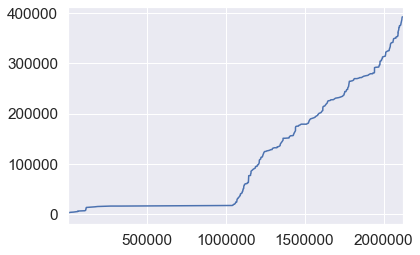

In [19]:
test_odo.plot()

## 3a. Making the Odometer for dockless

In [20]:
dockless['odometer'] = dockless.groupby('device_id')['trip_distance'].transform(pd.Series.cumsum)

## Verified that it works using a random device_id

In [21]:
dockless.loc[dockless.device_id == '1e5234a3-e86b-41e1-a1ad-e98310f3a71c']

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,2019,1556533800,1556533800,1.50,0.00,1.0,0
96,e0ea4c37-91c1-4e57-9393-1dd5b72e2f78,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,348,1183,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,2019,1556533800,1556533800,5.80,3.40,2.0,1183
598,d7ee689e-bfe2-4d38-8ef4-f75984493305,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,403,1173,04/29/2019 05:45:00 PM,04/29/2019 05:45:00 PM,4,17,1,2019,1556534700,1556534700,6.72,2.91,3.0,2356
883,c9b6872a-a8cd-4fb2-bf93-ec137130fc40,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,830,1851,05/10/2019 07:15:00 PM,05/10/2019 07:30:00 PM,5,19,5,2019,1557490500,1557491400,13.83,2.23,4.0,4207
8214,0fffd64c-5e46-4fac-a49c-3b5392c3260d,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,410,1193,05/26/2019 12:00:00 AM,05/26/2019 12:00:00 AM,5,0,0,2019,1558890000,1558890000,6.83,2.91,5.0,5400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375784,cf07cae4-3349-4f08-8248-f19361184036,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,433,243,03/17/2019 05:15:00 AM,03/17/2019 05:15:00 AM,3,5,0,2019,1552817700,1552817700,7.22,0.56,216.0,266919
5403792,c4684432-19f6-4b25-8062-4775edc03d4d,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,351,1505,04/03/2019 06:30:00 PM,04/03/2019 06:45:00 PM,4,18,3,2019,1554291000,1554291900,5.85,4.29,217.0,268424
5421176,a5f1d07d-0812-44ad-88d4-77cf84a6d44a,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,1632,3633,03/17/2019 07:30:00 PM,03/17/2019 08:00:00 PM,3,19,0,2019,1552825800,1552827600,27.20,2.23,218.0,272057
5429454,e6514671-b9a2-498f-bb93-a31fb6ccc58d,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,308,25,03/14/2019 07:15:00 PM,03/14/2019 07:15:00 PM,3,19,4,2019,1552565700,1552565700,5.13,0.08,219.0,272082


## 3b. Making the Odometer for bcycle

In [22]:
# odometer
bcycle['odometer'] = bcycle.groupby('bicycle_id')['trip_distance'].transform(pd.Series.cumsum)

In [23]:
# verify the odometer works
bcycle.loc[bcycle.bicycle_id == 207]

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.69,1.0,15323.69
151,9900286004,24-Hour Kiosk (Austin B-cycle),207,2707,Rainey St @ Cummings,2707,Rainey St @ Cummings,64,3840,1414354320,15,10,2014,0,12904.16,2.0,28227.85
207,9900286058,24-Hour Kiosk (Austin B-cycle),207,2707,Rainey St @ Cummings,2565,Trinity & 6th Street,205,12300,1414361520,17,10,2014,0,41333.64,3.0,69561.49
1908,9900287737,24-Hour Kiosk (Austin B-cycle),207,2707,Rainey St @ Cummings,2707,Rainey St @ Cummings,366,21960,1414681920,10,10,2014,4,73795.66,4.0,143357.15
2732,9900288549,24-Hour Kiosk (Austin B-cycle),207,2548,UT West Mall @ Guadalupe,2547,Guadalupe & 21st,142,8520,1414807920,21,10,2014,5,28631.10,5.0,171988.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973502,17870179,U.T. Student Membership,207,2565,Trinity & 6th Street,2565,Trinity & 6th Street,1,60,1530898377,12,7,2018,5,201.63,2556.0,12886574.94
974821,17888358,U.T. Student Membership,207,2565,Trinity & 6th Street,2542,Plaza Saltillo,10,600,1531016591,21,7,2018,6,2016.27,2557.0,12888591.21
974846,17888637,Local365,207,2542,Plaza Saltillo,3455,Republic Square @ 5th & Guadalupe,16,960,1531018637,21,7,2018,6,3226.04,2558.0,12891817.25
975735,17905005,U.T. Student Membership,207,3455,Republic Square @ 5th & Guadalupe,2537,West & 6th St.,6,360,1531176126,17,7,2018,1,1209.76,2559.0,12893027.01


# 4. Creating Classifiers: Trip Type (real ride or false start)

## Dockless Trip Type Classifier

In [24]:
# for dockless, real ride >= 1 meter traveled
mask_trip_class_dock = dockless['trip_distance'] > 0
# 0 = real ride; 1 = false start
dockless['trip_type'] = np.where(mask_trip_class_dock, 0, 1)

## Bcycle Trip Type Classifier

In [25]:
# for dockless, real real >= 3 meters
mask_trip_class_bcycle = bcycle['trip_duration_minutes'] >= 3
# 0 = real ride; 1 = false start
bcycle['trip_type'] = np.where(mask_trip_class_bcycle, 0, 1)

# 5. Downcast New Features 

## 5a. Reduce bcycle features to save memory

In [26]:
bcycle['trip_distance'] = pd.to_numeric(bcycle['trip_distance'], errors='ignore', downcast='integer')

In [27]:
bcycle['device_trip_count'] = pd.to_numeric(bcycle['device_trip_count'], errors='ignore', downcast='integer')

In [28]:
bcycle['odometer'] = pd.to_numeric(bcycle['odometer'], errors='ignore', downcast='integer')

In [29]:
bcycle['trip_type'] = pd.to_numeric(bcycle['trip_type'], errors='ignore', downcast='integer')

In [30]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id                 int16
checkout_kiosk_id          int16
checkout_kiosk            object
return_kiosk_id            int16
return_kiosk              object
trip_duration_minutes      int16
trip_duration_seconds      int16
unix_checkout_time         int32
hour                        int8
month                       int8
year                       int16
day_of_week                 int8
trip_distance            float64
device_trip_count          int16
odometer                 float64
trip_type                   int8
dtype: object

## 5b. Reduce dockless features to save memory

In [31]:
dockless['avg_speed'] = pd.to_numeric(dockless['avg_speed'], errors='ignore', downcast='float')

In [32]:
dockless['device_id_trip_count'] = pd.to_numeric(dockless['device_id_trip_count'], errors='ignore', downcast='integer')

In [33]:
dockless['odometer'] = pd.to_numeric(dockless['odometer'], errors='ignore', downcast='integer')

In [34]:
dockless['trip_type'] = pd.to_numeric(dockless['trip_type'], errors='ignore', downcast='integer')

In [35]:
dockless.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration_seconds      int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
year                       int16
unix_start_time            int32
unix_end_time              int32
trip_duration_minutes    float64
avg_speed                float32
device_id_trip_count       int16
odometer                   int64
trip_type                   int8
dtype: object

In [36]:
#Calling the variable again to include new features 
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['trip_duration_seconds'] >= 1)]

# Section IV: Data Exploration

## SelectKBest Features & Establish train_test_split

In [37]:
# instantiate the memberships using get_dummies
member_dummies = pd.get_dummies(bcycle.membership_type)

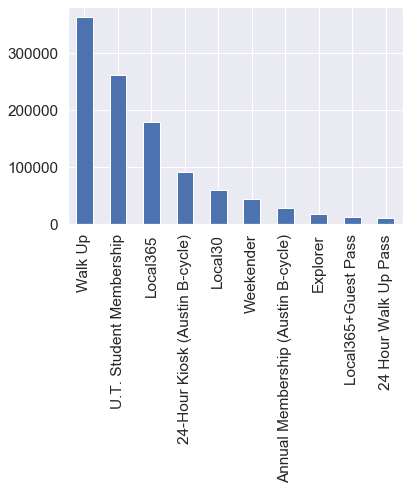

In [38]:
# plot the top 10 most popular memberships
bcycle.membership_type.value_counts()[0:10].plot(kind='bar')

In [39]:
# show the most used membership types
bcycle.membership_type.value_counts(ascending=False)

Walk Up                                               363176
U.T. Student Membership                               262383
Local365                                              179413
24-Hour Kiosk (Austin B-cycle)                         91201
Local30                                                59179
                                                       ...  
Annual Membership (Indy - Pacers Bikeshare )               8
PROHIBITED                                                 8
Local365 Youth (age 13-17 riders)- 1/2 off Special         3
Annual (Omaha B-cycle)                                     3
Annual Membership                                          3
Name: membership_type, Length: 70, dtype: int64

## SelectKBest - Bcycle

In [40]:
# count the number of unqiue bicycle ids;
# there are 593 unique ids
test1234 = pd.value_counts(bcycle['bicycle_id'].values, sort=False)
len(test1234)

593

In [41]:
%%time
# create test train split for bcycle data set

# drop columns the model can't read or serve as duplicates
X_b = bcycle.drop(['return_kiosk', 'return_kiosk_id', 'checkout_kiosk', 
                   'bicycle_id', 'trip_id'],  1)

# create category values so the model can interpret them
X_b = pd.get_dummies(X_b, columns=['year', 'hour', 'month', 'checkout_kiosk_id',
                                'day_of_week', 'trip_type','membership_type'])

# predicting for the return kiosk given the previous info in X_b
Y_b = bcycle['return_kiosk_id']

# test train split function
X_btrain, X_btest, y_btrain, y_btest = train_test_split(X_b, Y_b, test_size=0.25)

CPU times: user 3.17 s, sys: 724 ms, total: 3.9 s
Wall time: 4.16 s


In [42]:
%%time
# SelectKBest used to find the features with the most accuracy in order
selector_b = SelectKBest(k=25)
X_bnew = selector_b.fit_transform(X_btrain, y_btrain)
names_b = X_b.columns.values[selector_b.get_support()]
scores_b = selector_b.scores_[selector_b.get_support()]
names_scores_b = list(zip(names_b, scores_b))
ns_bcycle = pd.DataFrame(data = names_scores_b, 
                         columns=['Feat_names', 'F_Scores'])
ns_bcycle_sorted = ns_bcycle.sort_values(['F_Scores', 'Feat_names'], 
                                         ascending = [False, True])
print(ns_bcycle_sorted)

                                        Feat_names      F_Scores
23         membership_type_U.T. Student Membership  36968.199893
21               membership_type_HT Ram Membership   6859.214137
7                                        year_2018   6243.020071
0                               unix_checkout_time   5697.034084
16                          checkout_kiosk_id_4055   5294.736136
17                          checkout_kiosk_id_4059   3061.054931
15                          checkout_kiosk_id_3798   2874.163882
18                          checkout_kiosk_id_4061   2515.625324
19                          checkout_kiosk_id_4062   2201.687855
24                         membership_type_Walk Up   1845.948221
1                                device_trip_count   1269.873278
4                                        year_2015   1172.433899
3                                        year_2014   1138.117497
12                          checkout_kiosk_id_3377   1128.285501
22                       

## SelectKBest - Dockless

In [43]:
%%time
# create test train split for bcycle data set

# drop columns the model can't read or serve as duplicates
X_d = normal_dockless_rides.drop(['device_id', 'id', 'start_time',
                                  'end_time', 'trip_type',
                                  'trip_duration_minutes'], 1)

# create category values so the model can interpret them
X_d = pd.get_dummies(X_d, columns=['year', 'hour', 'month',
                                   'vehicle_type','day_of_week'])
    
# predicting for the trip distance given the previous info in X_d
y_d = normal_dockless_rides['trip_distance']

# test train split function
X_dtrain, X_dtest, y_dtrain, y_dtest = train_test_split(X_d, y_d, test_size=0.25)

CPU times: user 4.86 s, sys: 1.06 s, total: 5.92 s
Wall time: 6.34 s


In [44]:
%%time
# there are a few infinity time values that need to be replaced
inf_test = X_d.replace([np.inf, -np.inf], np.nan)
inf_test.dropna()
len(inf_test)

CPU times: user 59.9 s, sys: 13.1 s, total: 1min 12s
Wall time: 1min 17s


4971999

In [45]:
len(inf_test)

4971999

In [46]:
%%time
# SelectKBest used to find the features with the most accuracy in order
selector_d = SelectKBest(k=25)
X_dnew = selector_d.fit_transform(X_dtrain, y_dtrain)
names_d = X_d.columns.values[selector_d.get_support()]
scores_d = selector_d.scores_[selector_d.get_support()]
names_scores_d = list(zip(names_d, scores_d))
ns_dockless = pd.DataFrame(data = names_scores_d, 
                         columns=['Feat_names', 'F_Scores'])
ns_dockless_sorted = ns_dockless.sort_values(['F_Scores', 'Feat_names'], 
                                         ascending = [False, True])
print(ns_dockless_sorted)

/Users/jakegrosek/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


               Feat_names     F_Scores
1           trip_distance          inf
4               avg_speed  1090.434242
22   vehicle_type_scooter    62.713604
21   vehicle_type_bicycle    62.713604
7               year_2018    39.122030
8               year_2019    39.122030
0   trip_duration_seconds    32.388100
3           unix_end_time    31.916110
2         unix_start_time    31.915447
18               month_10    28.069993
19               month_11     8.589321
11                month_3     7.112276
5    device_id_trip_count     7.016035
16                month_8     5.582905
17                month_9     5.299449
13                month_5     4.871047
6                odometer     4.664238
12                month_4     4.414567
15                month_7     3.371541
20               month_12     3.000092
14                month_6     2.741120
24          day_of_week_6     2.488442
23          day_of_week_0     2.464656
10                month_2     2.197774
9                 hour_14

# Bcycle Heatmaps

## Master Heatmap with all features

CPU times: user 834 ms, sys: 314 ms, total: 1.15 s
Wall time: 1.42 s


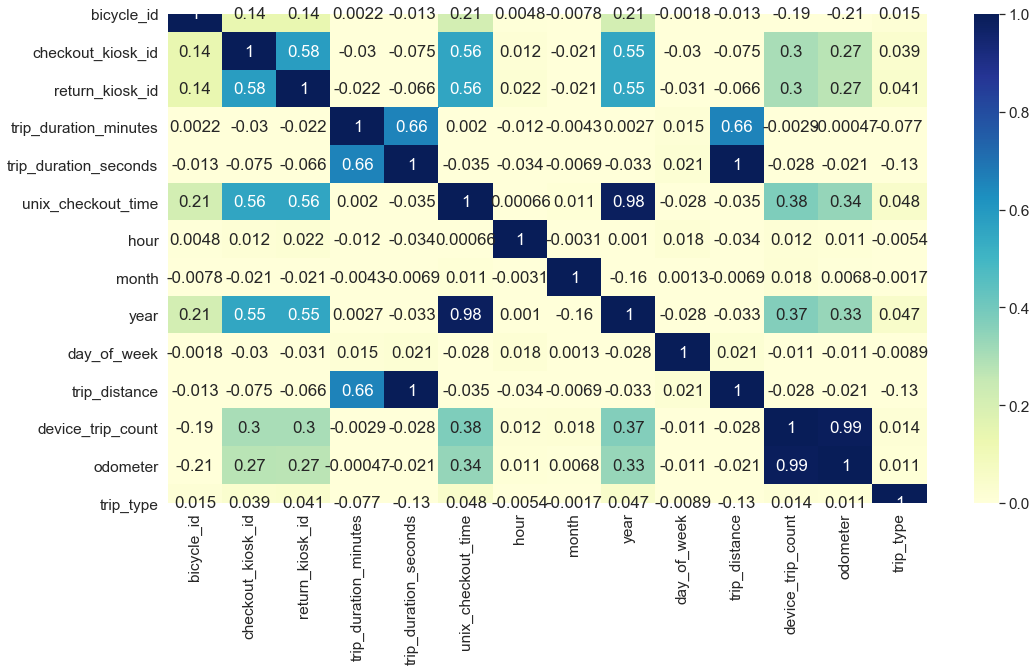

In [47]:
%%time
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
sns.set(font_scale=1.4) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu",
                             vmin=0, vmax=1, annot=True, cbar=True)

## Day of Week

CPU times: user 1.49 s, sys: 145 ms, total: 1.63 s
Wall time: 1.56 s


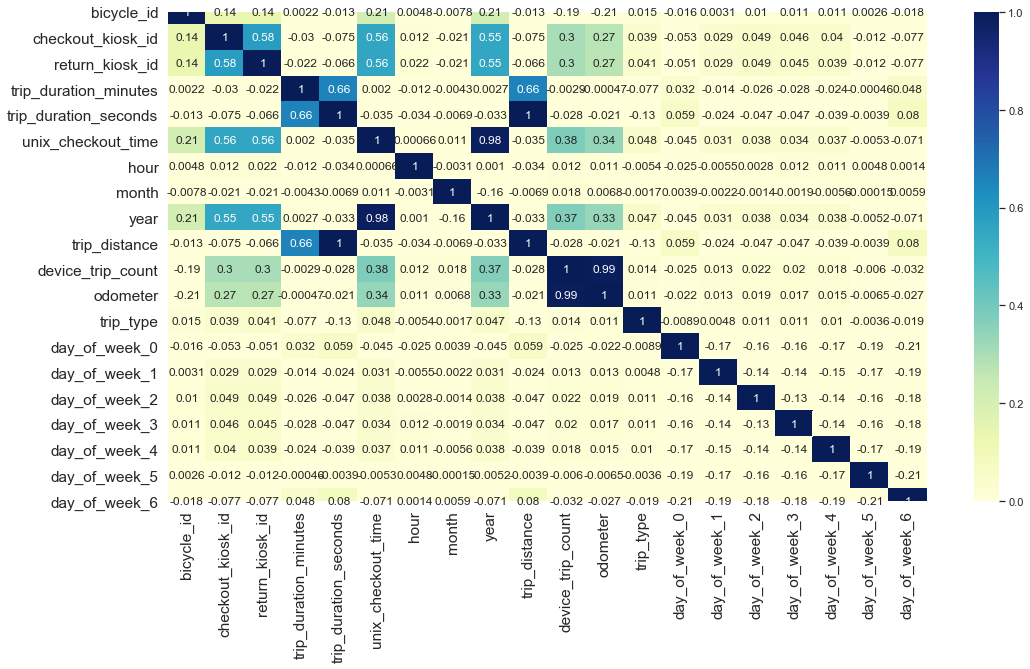

In [48]:
%%time
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['day_of_week'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
sns.set(font_scale=1.0) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu",
                             vmin=0, vmax=1, annot=True, cbar=True)

## Hour 

CPU times: user 4.02 s, sys: 609 ms, total: 4.63 s
Wall time: 4.86 s


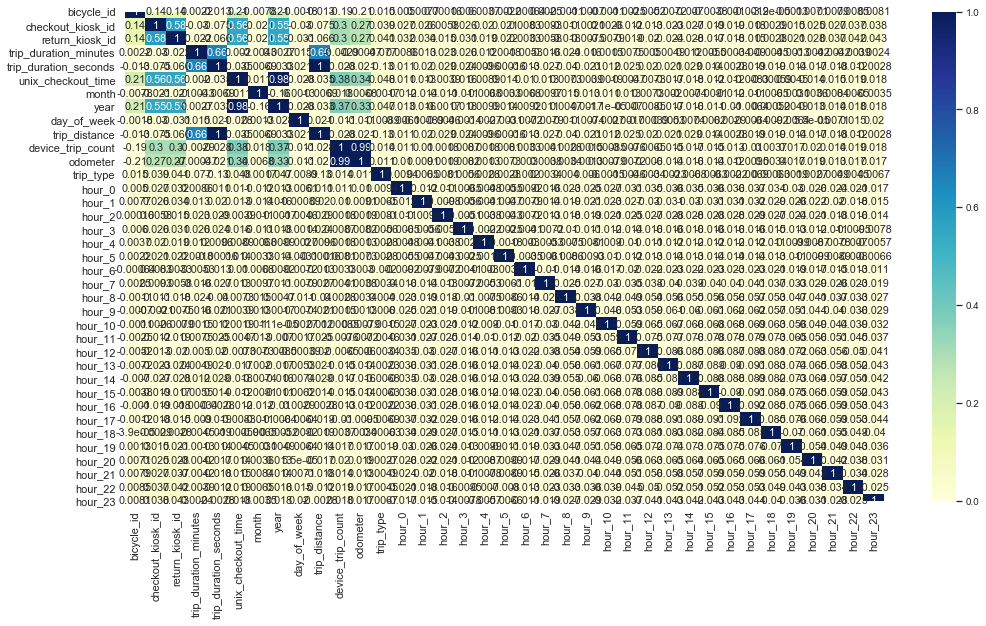

In [49]:
%%time
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['hour'])
corr_bcycle = heat_bcycle.corr()

# did not annotate since the boxes and fonts were too small
fig, ax = plt.subplots(figsize=(17,9)) 
sns.set(font_scale=0.9) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu",
                             vmin=0, vmax=1, annot=True, cbar=True)

## Month

CPU times: user 2.09 s, sys: 158 ms, total: 2.25 s
Wall time: 2.19 s


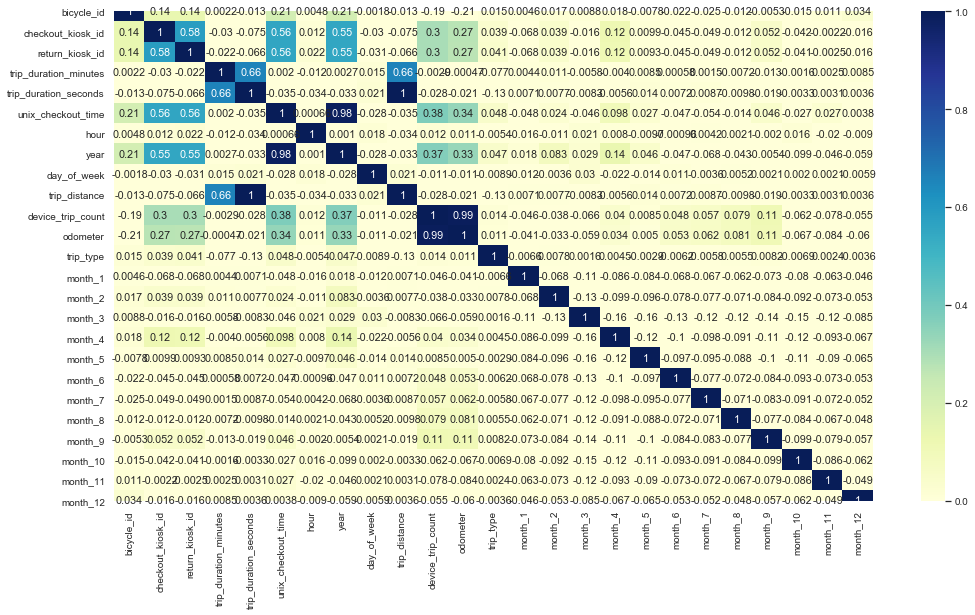

In [50]:
%%time
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['month'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
sns.set(font_scale=0.9) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", 
                             annot=True, vmin=0, vmax=1, cbar=True)

## Year

CPU times: user 1.6 s, sys: 143 ms, total: 1.74 s
Wall time: 1.66 s


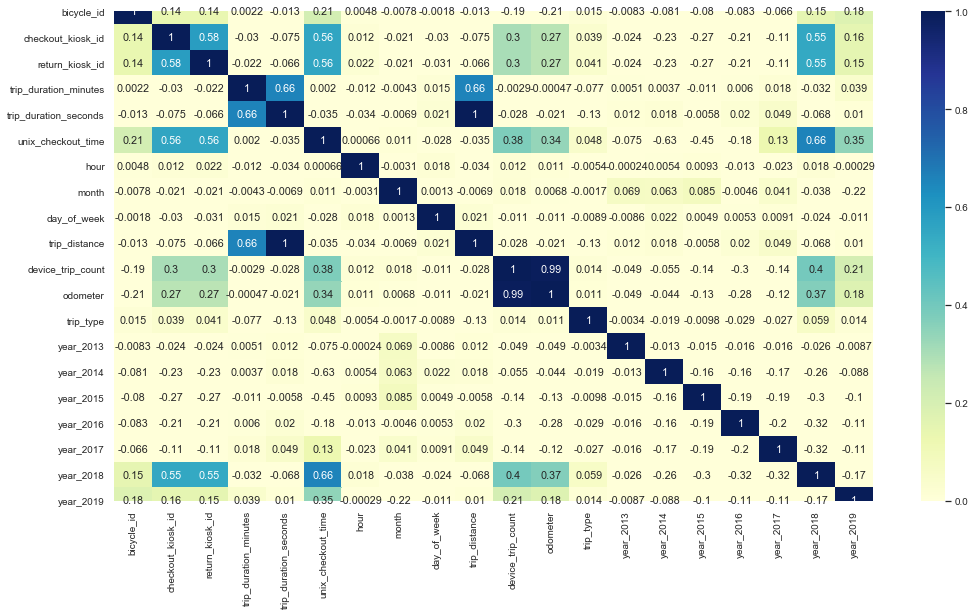

In [51]:
%%time
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['year'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
sns.set(font_scale=0.9) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0,
                             vmax=1, annot=True, cbar=True)

## Trip_type

CPU times: user 1.02 s, sys: 123 ms, total: 1.15 s
Wall time: 1.11 s


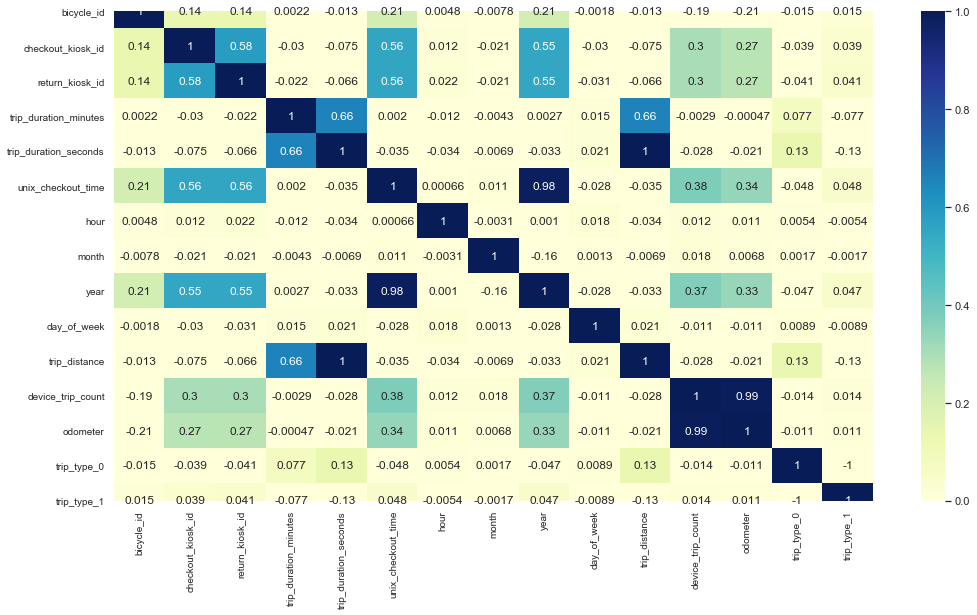

In [52]:
%%time
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['trip_type'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9))
sns.set(font_scale=1.0) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu",
                             vmin=0, vmax=1, annot=True, cbar=True)

# Dockless Heatmaps

## Master Heatmap with all features

CPU times: user 2.59 s, sys: 1.65 s, total: 4.24 s
Wall time: 5.17 s


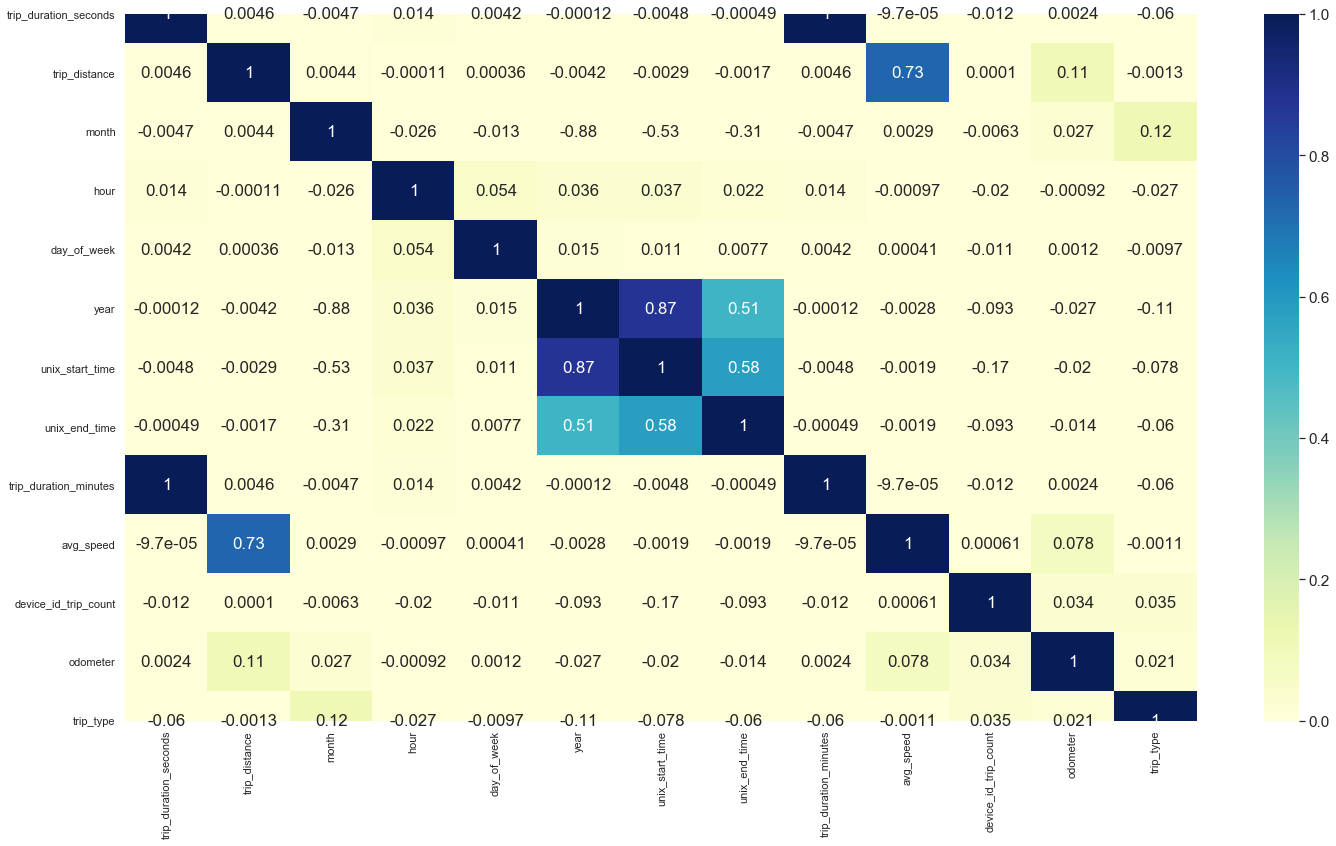

In [53]:
%%time
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(24,13))
sns.set(font_scale=1.4) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

## Day of the week

CPU times: user 6.14 s, sys: 894 ms, total: 7.03 s
Wall time: 6.98 s


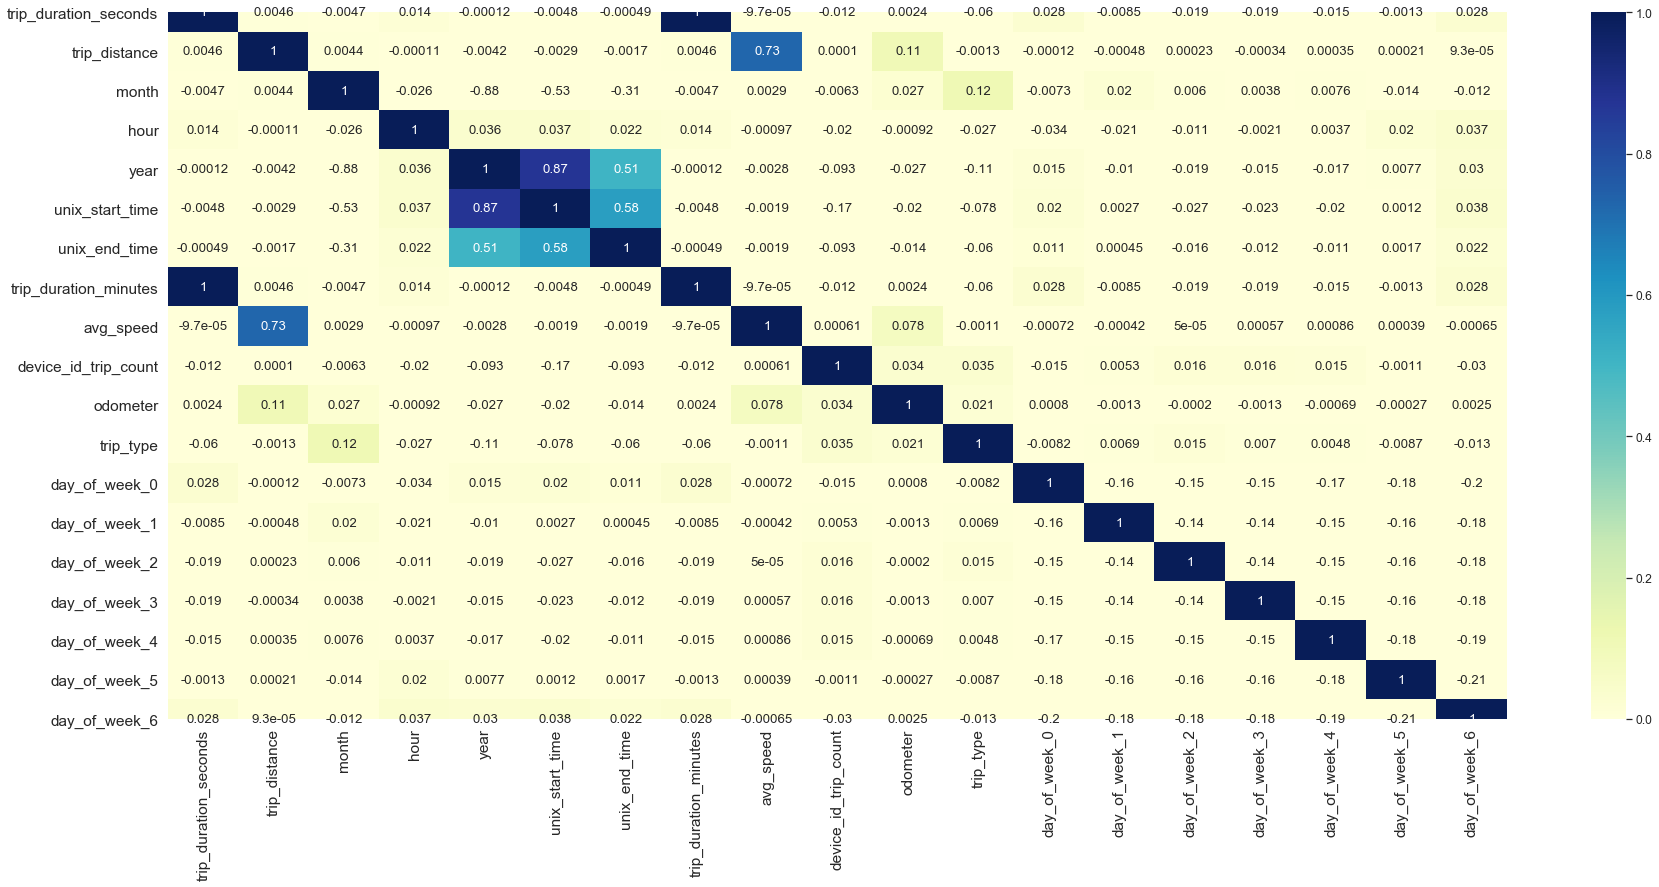

In [54]:
%%time
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['day_of_week'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
sns.set(font_scale=1.1) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

## Hour

CPU times: user 15.9 s, sys: 1.4 s, total: 17.3 s
Wall time: 17.6 s


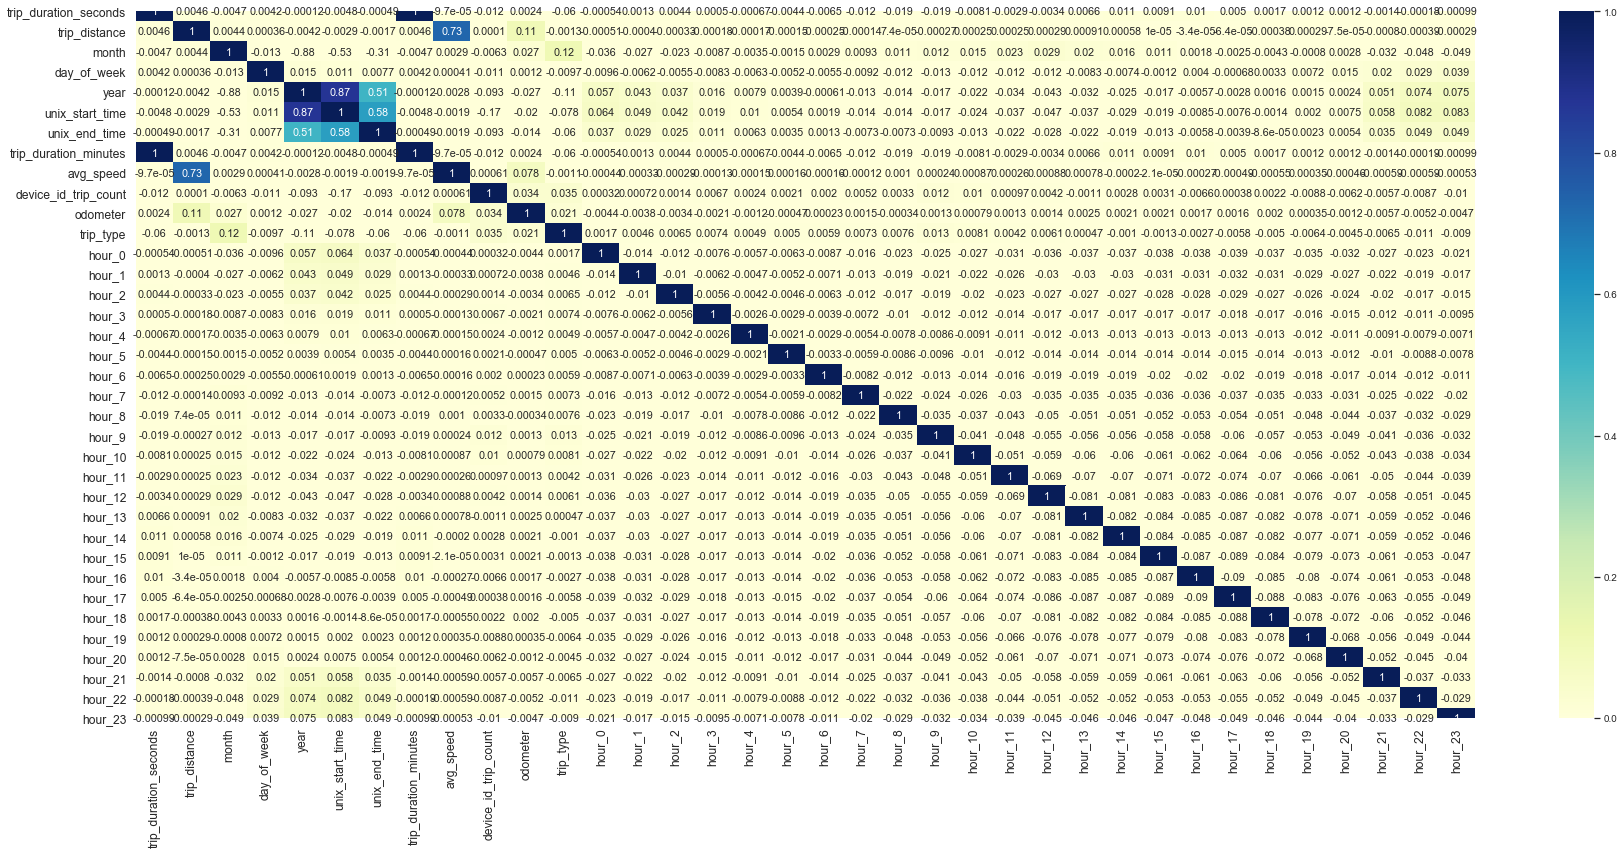

In [55]:
%%time
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['hour'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
sns.set(font_scale=0.9) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

## Month

CPU times: user 8.02 s, sys: 925 ms, total: 8.95 s
Wall time: 8.89 s


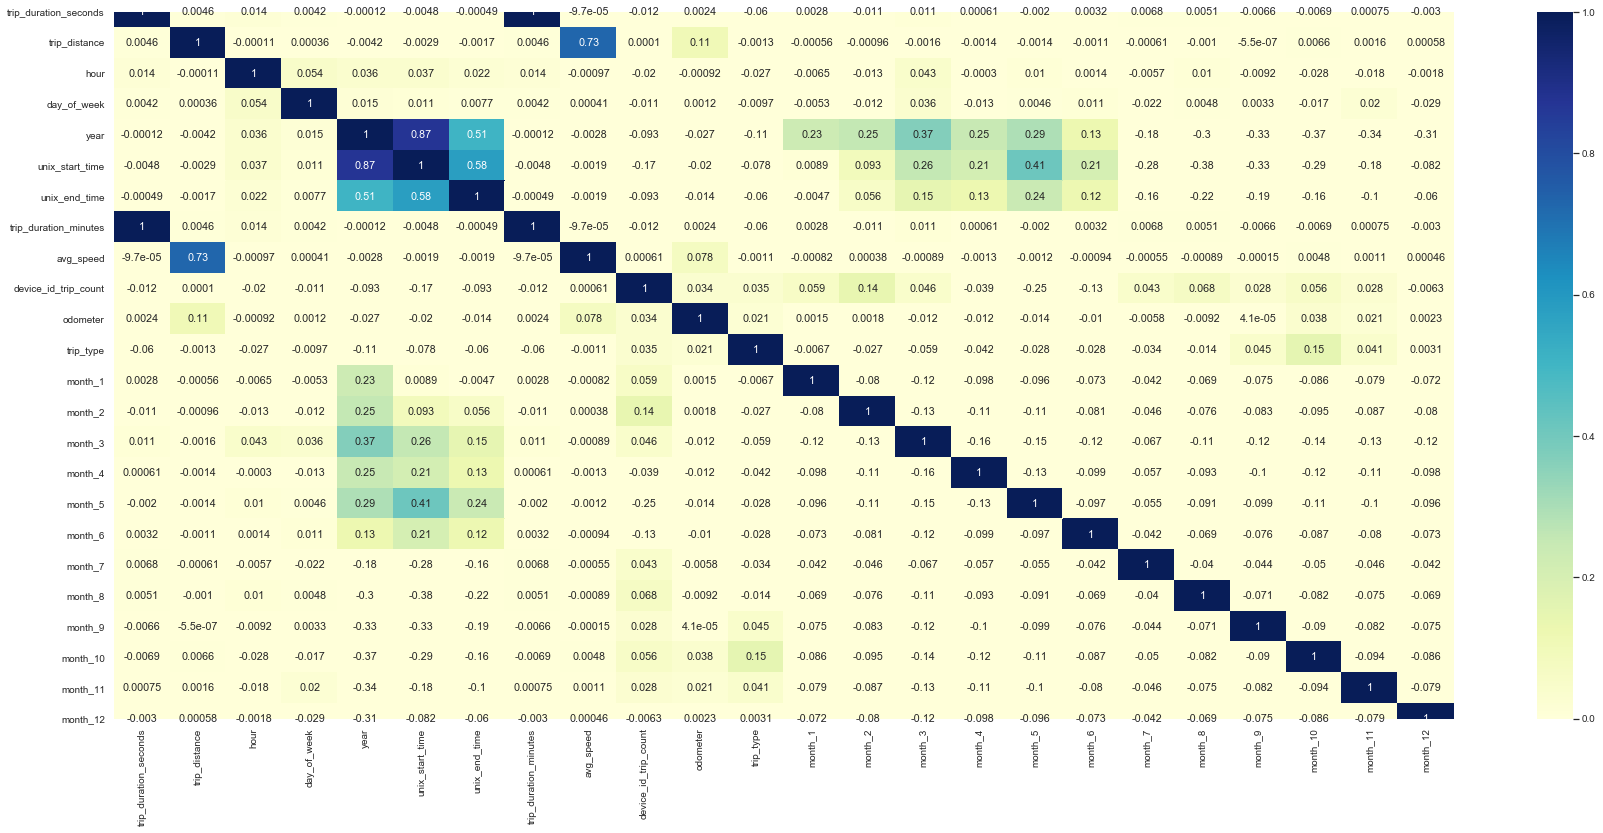

In [56]:
%%time
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['month'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
sns.set(font_scale=0.9) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

## Year

CPU times: user 3.87 s, sys: 661 ms, total: 4.54 s
Wall time: 4.46 s


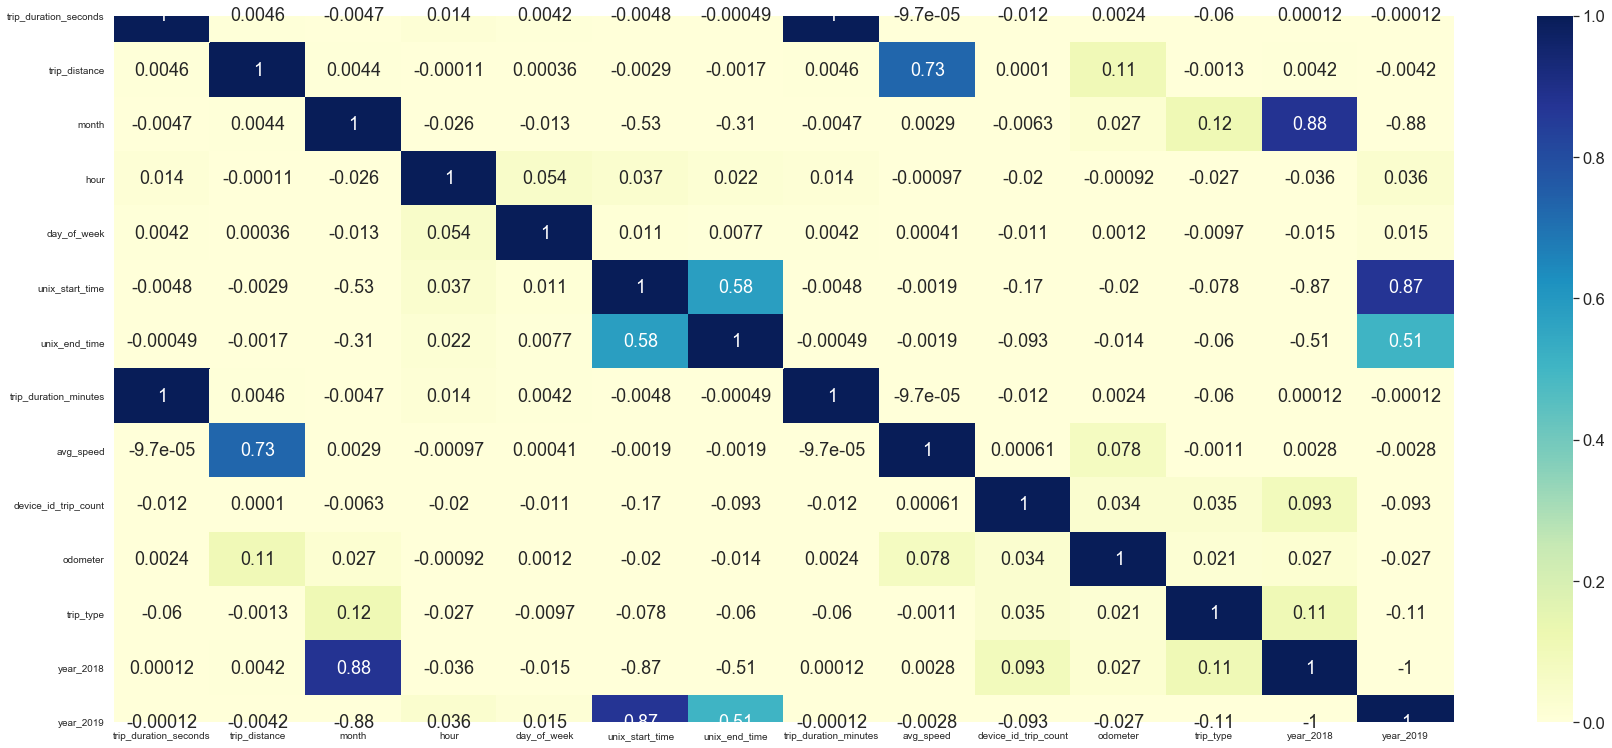

In [57]:
%%time
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['year'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
sns.set(font_scale=1.5) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

## Trip Type

CPU times: user 4.03 s, sys: 704 ms, total: 4.74 s
Wall time: 4.66 s


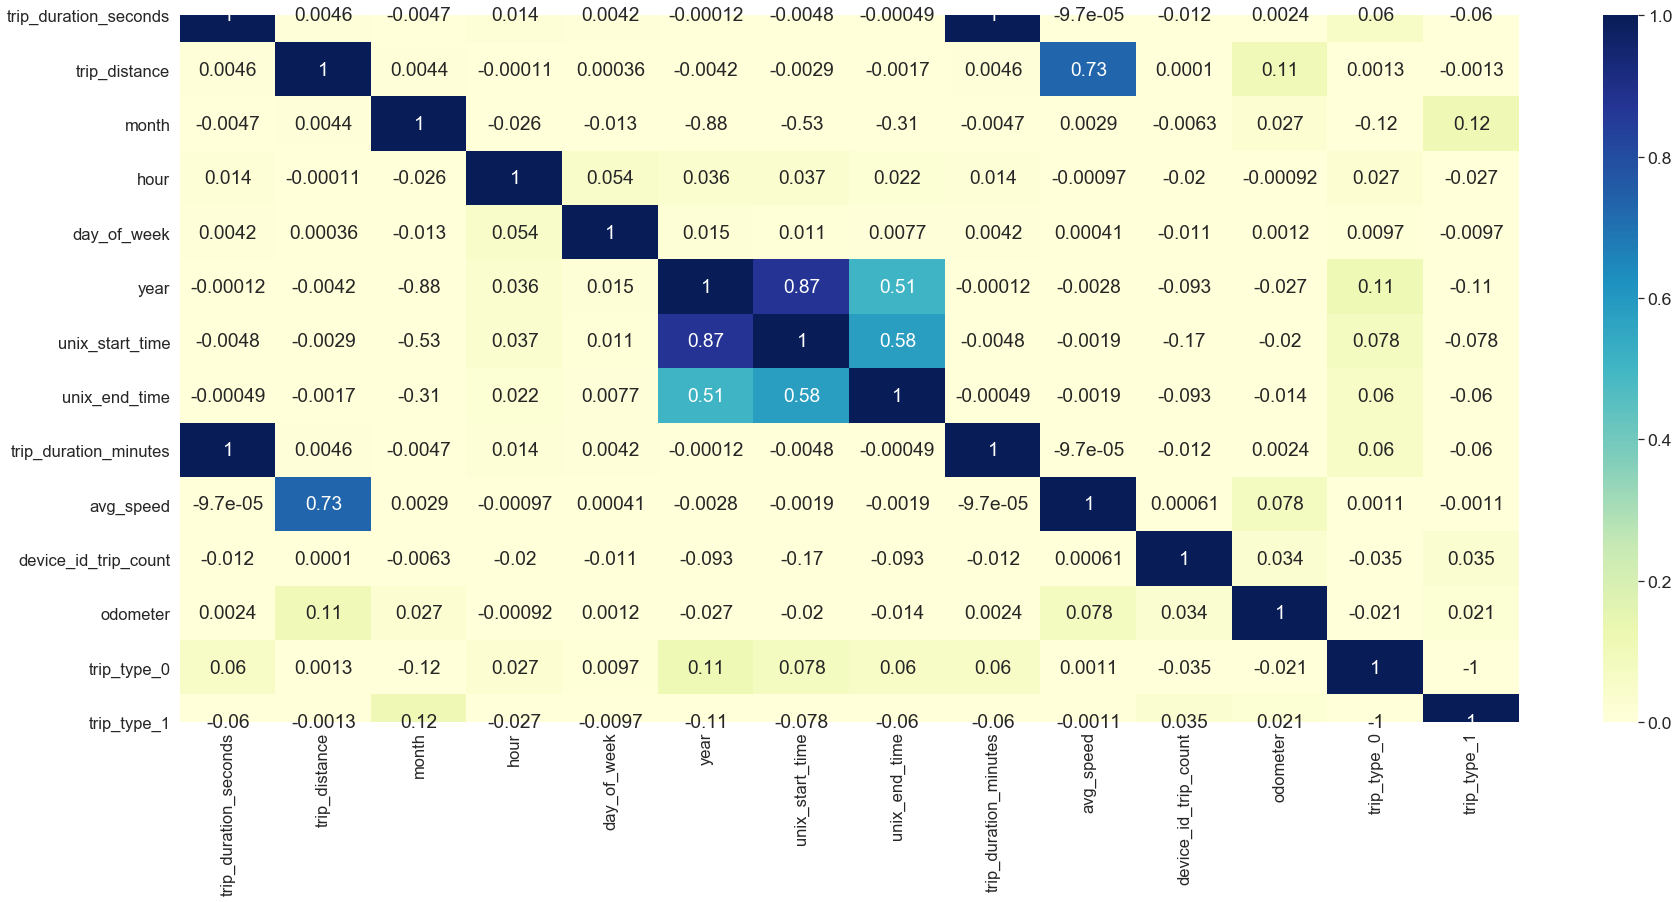

In [58]:
%%time
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['trip_type'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
sns.set(font_scale=1.6) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

## Vehicle Type

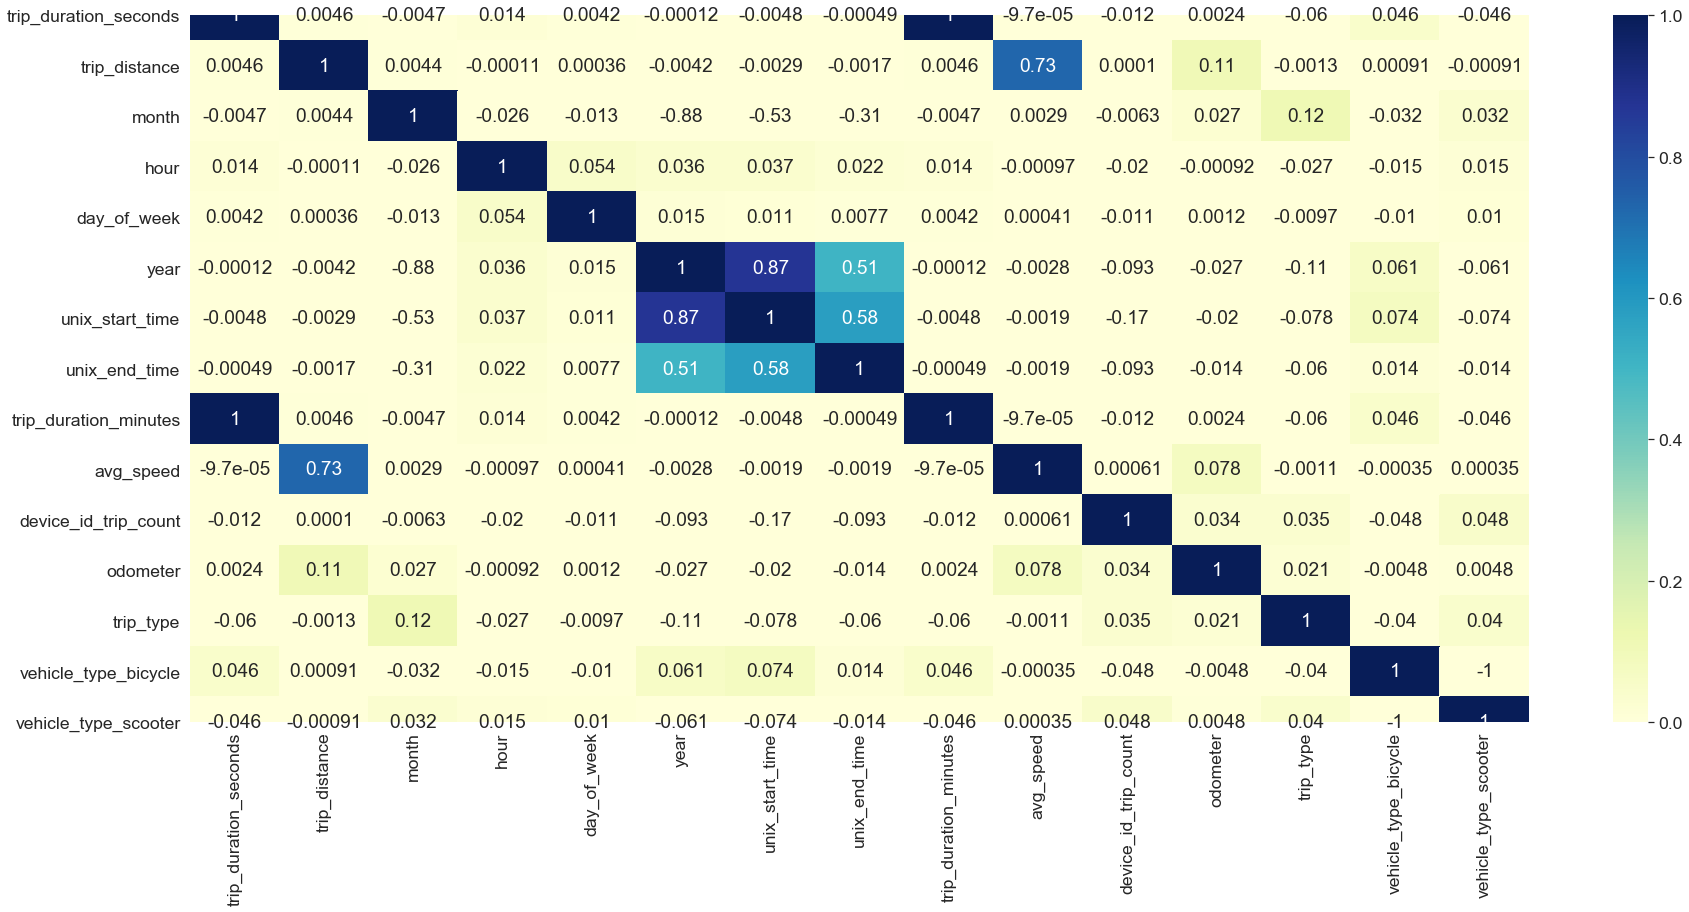

In [59]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['vehicle_type'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
sns.set(font_scale=1.6) 

heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu",
                           vmin=0, vmax=1, annot=True, cbar=True)

# Pickle the notebooks

In [60]:
dockless.to_pickle('./dockless_feature_engineering.pkl')

In [61]:
bcycle.to_pickle('./bcycle_feature_engineering.pkl')